In [266]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from glob import glob
import os

# Directory where your data files are stored
data_dir = '../data/'

# Find all Excel files for 2024 data
data_files = glob(os.path.join(data_dir, '*_2024_ae_data.xls'))

# Define headers
headers = [
    'Code', 'System', 'Type 1 Departments', 'Type 2 Departments', 'Type 3 Departments',
    'Total Attendances', 'Attendances < 4 hours (Type 1)', 'Attendances < 4 hours (Type 2)',
    'Attendances < 4 hours (Type 3)', 'Total Attendances < 4 hours', 'Attendances > 4 hours (Type 1)',
    'Attendances > 4 hours (Type 2)', 'Attendances > 4 hours (Type 3)', 'Total Attendances > 4 hours',
    'Percentage in 4 hours (all)', 'Percentage in 4 hours (Type 1)', 'Percentage in 4 hours (Type 2)',
    'Percentage in 4 hours (Type 3)', 'Emergency Admissions Type 1', 'Emergency Admissions Type 2',
    'Emergency Admissions Type 3 and 4', 'Total Emergency Admissions via A&E',
    'Other Emergency Admissions (not via A&E)', 'Total Emergency Admissions',
    'Patients spending >4 hours from decision to admit', 'Patients spending >12 hours from decision to admit'
]

# List to store all data
all_data_frames = []

# Read and clean each file
for file in data_files:
    # Extract month name from the filename  ("january_2024_ae_data.xls")
    file_name = os.path.basename(file)
    month_name = file_name.split('_')[0]  # Extract "january" from "january_2024_ae_data.xls"

    # Convert month name to a numeric month
    month_number = pd.to_datetime(month_name + ' 2024', format='%B %Y').month  

    # Read Excel file and skip metadata rows
    data = pd.read_excel(file, engine='xlrd', skiprows=17, header=None, names=headers)

    # Remove invalid rows (e.g., empty or placeholder rows)
    data = data[data['System'].notna() & (data['System'] != '-')]

    # Convert relevant columns to numeric
    numeric_columns = [
        'Total Attendances', 'Total Attendances < 4 hours', 'Total Attendances > 4 hours',
        'Emergency Admissions Type 1', 'Patients spending >4 hours from decision to admit'
    ]
    data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

    # Drop rows with missing required data
    data = data.dropna(subset=['Total Attendances', 'Total Attendances < 4 hours'])

    # Add 'Month' column based on the filename
    data['Month'] = month_number

    # Add calculated field: Percentage Seen Within 4 Hours
    data['Percentage_Under_4_Hours'] = (data['Total Attendances < 4 hours'] / data['Total Attendances']) * 100

    # Append cleaned data to the list
    all_data_frames.append(data)

# Combine all monthly data into a single DataFrame
combined_data = pd.concat(all_data_frames, ignore_index=True)

# Define function to map months to seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Apply season mapping to the combined data
combined_data['Season'] = combined_data['Month'].map(get_season)

# Print combined data preview with season column
print("\nCombined Data with Season Column:")
print(combined_data[['Month', 'Season']].head(12))


# Define holidays and events for each month in the UK
holidays_events_uk = pd.DataFrame({
    'Month': [1, 2, 3, 3, 4, 4, 5, 5, 8, 11, 11, 12, 12],
    'Holiday_Event': [
        'New Year\'s Day', 'Valentine\'s Day', 'St. Patrick\'s Day', 'Mothering Sunday',
        'Good Friday', 'Easter Monday', 'Early May Bank Holiday', 'Spring Bank Holiday',
        'Summer Bank Holiday', 'Guy Fawkes Night', 'Remembrance Sunday',
        'Christmas Day', 'Boxing Day'
    ]
})

# Create a column indicating if the month contains holidays/events
combined_data['Holiday_Event_Month'] = combined_data['Month'].apply(lambda x: 1 if x in holidays_events_uk['Month'].values else 0)

# Print combined data preview with holiday/event column
print("\nCombined Data with Holiday/Event Column:")
print(combined_data[['Month', 'Holiday_Event_Month']].head(12))

# Save the combined dataset
combined_data.to_csv('../data/combined_2024_ae_data.csv', index=False)
print("Combined data saved to '../data/combined_2024_ae_data.csv'.")

# Preview the first few rows
print("\nFinal Combined Data Preview:")
print(combined_data.head())



Combined Data with Season Column:
    Month  Season
0       2  Winter
1       2  Winter
2       2  Winter
3       2  Winter
4       2  Winter
5       2  Winter
6       2  Winter
7       2  Winter
8       2  Winter
9       2  Winter
10      2  Winter
11      2  Winter

Combined Data with Holiday/Event Column:
    Month  Holiday_Event_Month
0       2                    1
1       2                    1
2       2                    1
3       2                    1
4       2                    1
5       2                    1
6       2                    1
7       2                    1
8       2                    1
9       2                    1
10      2                    1
11      2                    1
Combined data saved to '../data/combined_2024_ae_data.csv'.

Final Combined Data Preview:
  Code                                             System  Type 1 Departments  \
0  QOX  NHS Bath And North East Somerset, Swindon And ...             17493.0   
1  QHG  NHS Bedfordshire, Luton An


Aggregated Data by Season:
   Season  Total Attendances
0  Autumn          6881635.0
1  Spring          7027181.0
2  Summer          6779688.0
3  Winter          6734581.0


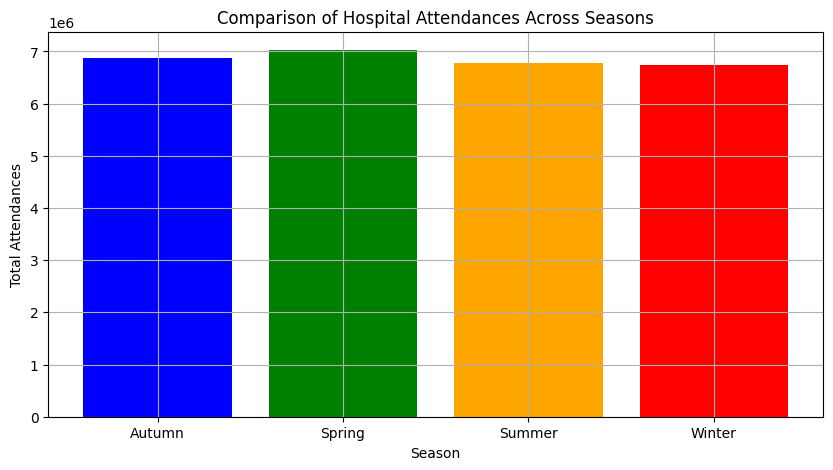

In [267]:
# Aggregate attendances by season
seasonal_attendances = combined_data.groupby('Season')['Total Attendances'].sum().reset_index()

# Print aggregated data by season
print("\nAggregated Data by Season:")
print(seasonal_attendances)

# Plot comparison of attendances across seasons
plt.figure(figsize=(10, 5))
plt.bar(seasonal_attendances['Season'], seasonal_attendances['Total Attendances'], color=['blue', 'green', 'orange', 'red'])
plt.title("Comparison of Hospital Attendances Across Seasons")
plt.xlabel("Season")
plt.ylabel("Total Attendances")
plt.grid()
plt.show()



Average Attendances in Holiday/Event Months: 2279222.75
Average Attendances in Non-Holiday/Event Months: 2297325.75


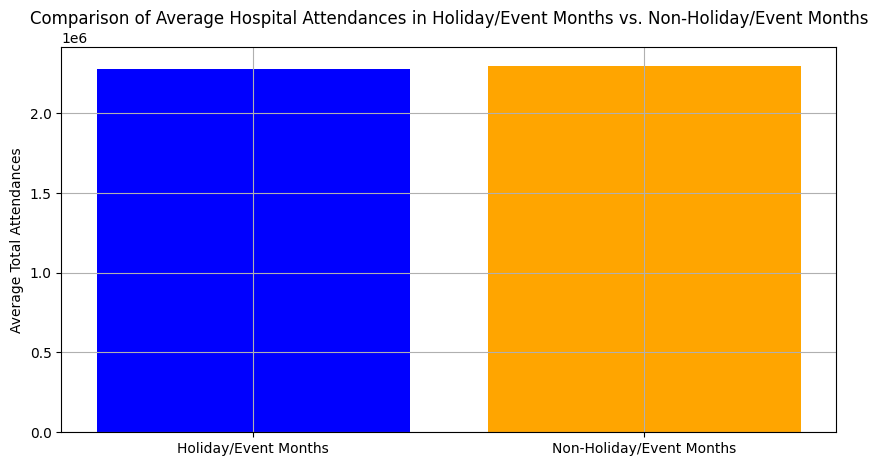

In [268]:
# Aggregate attendances by holiday/event months vs. non-holiday/event months
holiday_event_attendances = combined_data[combined_data['Holiday_Event_Month'] == 1].groupby('Month')['Total Attendances'].sum().reset_index()
non_holiday_event_attendances = combined_data[combined_data['Holiday_Event_Month'] == 0].groupby('Month')['Total Attendances'].sum().reset_index()

# Calculate average attendances for comparison
avg_holiday_event_attendances = holiday_event_attendances['Total Attendances'].mean()
avg_non_holiday_event_attendances = non_holiday_event_attendances['Total Attendances'].mean()

print(f"\nAverage Attendances in Holiday/Event Months: {avg_holiday_event_attendances}")
print(f"Average Attendances in Non-Holiday/Event Months: {avg_non_holiday_event_attendances}")

# Plot the comparison
plt.figure(figsize=(10, 5))
plt.bar(['Holiday/Event Months', 'Non-Holiday/Event Months'], [avg_holiday_event_attendances, avg_non_holiday_event_attendances], color=['blue', 'orange'])
plt.title("Comparison of Average Hospital Attendances in Holiday/Event Months vs. Non-Holiday/Event Months")
plt.ylabel("Average Total Attendances")
plt.grid()
plt.show()


In [276]:
# Generate synthetic data with adjusted variance and mean
def generate_synthetic_data(start_date, end_date, freq='h', seed=42):
    idx = pd.date_range(start=start_date, end=end_date, freq=freq)
    rng = np.random.default_rng(seed=seed)
    wait_times = rng.normal(loc=240, scale=120, size=len(idx))  # Increased mean and variance
    wait_times = np.clip(wait_times, 10, 600)  # Ensuring values are within a logical range
    return pd.DataFrame(index=idx, data=wait_times, columns=["wait_time_minutes"])

synthetic_df = generate_synthetic_data(start_date='2024-01-01', end_date='2024-12-31')

# Categorize into Under 4 Hours and Over 4 Hours
synthetic_df['Under_4_Hours'] = (synthetic_df['wait_time_minutes'] <= 240).astype(int)
synthetic_df['Over_4_Hours'] = (synthetic_df['wait_time_minutes'] > 240).astype(int)

# Ensure 'Month' column exists
synthetic_df['Month'] = synthetic_df.index.month

# Define function for seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Apply season mapping
synthetic_df['season'] = synthetic_df['Month'].map(get_season)

# Define function for day/night
def day_or_night(hour):
    return 'Day' if 7 <= hour < 19 else 'Night'

# Apply day/night feature
synthetic_df['day_or_night'] = synthetic_df.index.hour.map(day_or_night)

# Aggregate by month for comparison
synthetic_monthly = synthetic_df.resample('ME').sum()[['Under_4_Hours', 'Over_4_Hours']]
synthetic_monthly['Month'] = synthetic_monthly.index.month
synthetic_monthly.reset_index(drop=True, inplace=True)

# Scale Synthetic Data to Match Real Data Magnitude for Under 4 Hours
real_under4_monthly = combined_data.groupby('Month')[['Total Attendances < 4 hours']].sum().reset_index()
scaling_factor_under4 = real_under4_monthly['Total Attendances < 4 hours'].sum() / synthetic_monthly['Under_4_Hours'].sum()
synthetic_monthly['Under_4_Hours_Scaled'] = synthetic_monthly['Under_4_Hours'] * scaling_factor_under4

# Scale Synthetic Data to Match Real Data Magnitude for Over 4 Hours
real_over4_monthly = combined_data.groupby('Month')[['Total Attendances > 4 hours']].sum().reset_index()
scaling_factor_over4 = real_over4_monthly['Total Attendances > 4 hours'].sum() / synthetic_monthly['Over_4_Hours'].sum()
synthetic_monthly['Over_4_Hours_Scaled'] = synthetic_monthly['Over_4_Hours'] * scaling_factor_over4


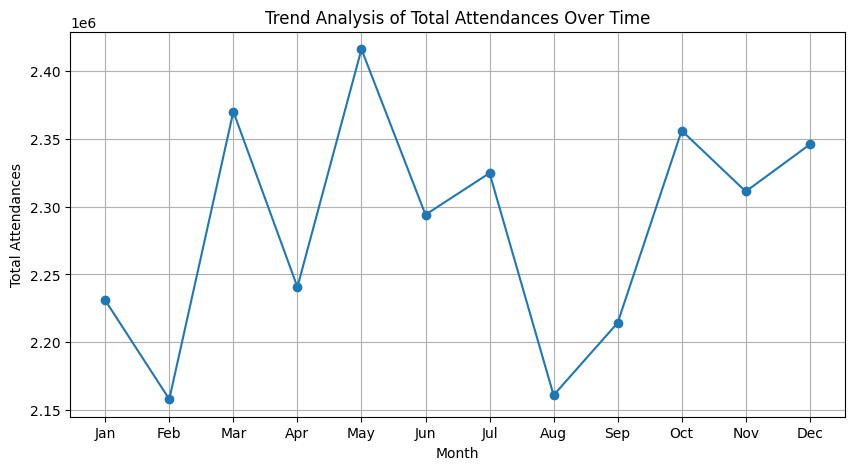

In [270]:
# Plot trend analysis of Total Attendances over time
plt.figure(figsize=(10, 5))
plt.plot(combined_data.groupby('Month')['Total Attendances'].sum(), marker='o')
plt.title("Trend Analysis of Total Attendances Over Time")
plt.xlabel("Month")
plt.ylabel("Total Attendances")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid()
plt.show()


/var/folders/12/9jvww_b906s7rr1mrprk45v80000gn/T/ipykernel_86033/3468296844.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  idx = pd.date_range(start=start_date, end=end_date, freq=freq)


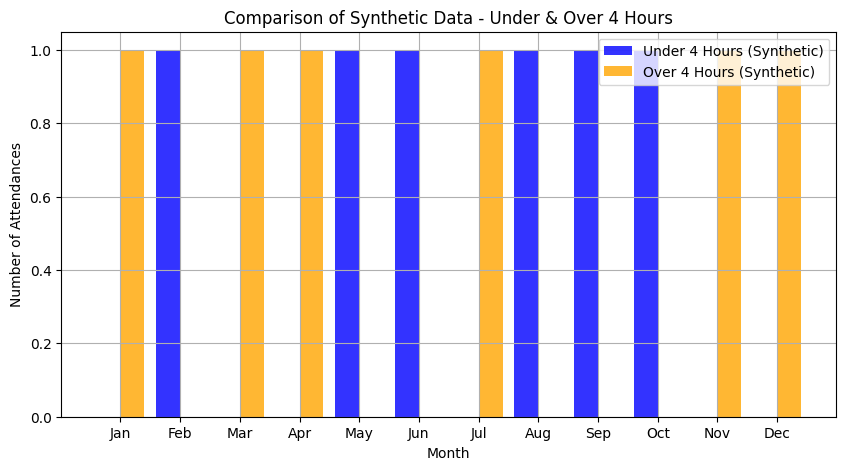

In [277]:
# Re-import necessary libraries after execution state reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data with adjusted variance and mean
def generate_synthetic_data(start_date, end_date, freq='M', seed=42):
    idx = pd.date_range(start=start_date, end=end_date, freq=freq)
    rng = np.random.default_rng(seed=seed)
    wait_times = rng.normal(loc=240, scale=120, size=len(idx))  # Increased mean and variance
    wait_times = np.clip(wait_times, 10, 600)  # Ensuring values are within a logical range
    return pd.DataFrame(index=idx, data=wait_times, columns=["wait_time_minutes"])

# Creating synthetic dataset for 2024
synthetic_df = generate_synthetic_data(start_date='2024-01-01', end_date='2024-12-31')

# Categorize into Under 4 Hours and Over 4 Hours
synthetic_df['Under_4_Hours'] = (synthetic_df['wait_time_minutes'] <= 240).astype(int)
synthetic_df['Over_4_Hours'] = (synthetic_df['wait_time_minutes'] > 240).astype(int)

# Extract Month for Aggregation
synthetic_df['Month'] = synthetic_df.index.month

# Aggregate by month for comparison
synthetic_monthly = synthetic_df.groupby('Month')[['Under_4_Hours', 'Over_4_Hours']].sum().reset_index()

# Plot synthetic data comparison
plt.figure(figsize=(10, 5))
plt.bar(synthetic_monthly['Month'] - 0.2, synthetic_monthly['Under_4_Hours'], width=0.4, label="Under 4 Hours (Synthetic)", alpha=0.8, color='blue')
plt.bar(synthetic_monthly['Month'] + 0.2, synthetic_monthly['Over_4_Hours'], width=0.4, label="Over 4 Hours (Synthetic)", alpha=0.8, color='orange')

plt.title("Comparison of Synthetic Data - Under & Over 4 Hours")
plt.xlabel("Month")
plt.ylabel("Number of Attendances")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid()
plt.show()


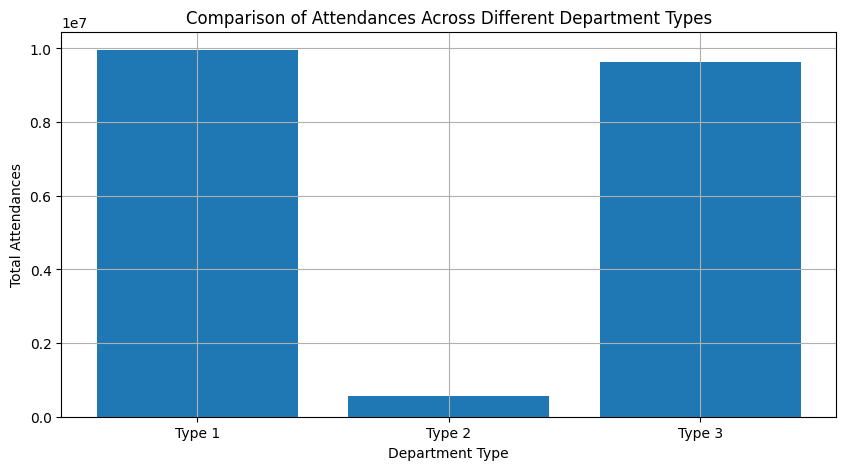

In [271]:
# Aggregate and plot comparison of attendances across different department types
department_types = ['Type 1', 'Type 2', 'Type 3']
total_attendances_types = combined_data[['Attendances < 4 hours (Type 1)', 'Attendances < 4 hours (Type 2)', 'Attendances < 4 hours (Type 3)']].sum()

plt.figure(figsize=(10, 5))
plt.bar(department_types, total_attendances_types)
plt.title("Comparison of Attendances Across Different Department Types")
plt.xlabel("Department Type")
plt.ylabel("Total Attendances")
plt.grid()
plt.show()


In [272]:
# Provide statistical summary of attendances under and over 4 hours
under_4_stats = combined_data['Total Attendances < 4 hours'].describe()
over_4_stats = combined_data['Total Attendances > 4 hours'].describe()

print("\nStatistical Summary of Attendances < 4 Hours:")
print(under_4_stats)

print("\nStatistical Summary of Attendances > 4 Hours:")
print(over_4_stats)



Statistical Summary of Attendances < 4 Hours:
count       504.000000
mean      39938.470238
std       23027.482334
min        8881.000000
25%       23707.250000
50%       31244.000000
75%       52194.500000
max      115118.000000
Name: Total Attendances < 4 hours, dtype: float64

Statistical Summary of Attendances > 4 Hours:
count      504.000000
mean     14472.412698
std       8060.250562
min       3662.000000
25%       8877.500000
50%      12604.500000
75%      17817.250000
max      46991.000000
Name: Total Attendances > 4 hours, dtype: float64


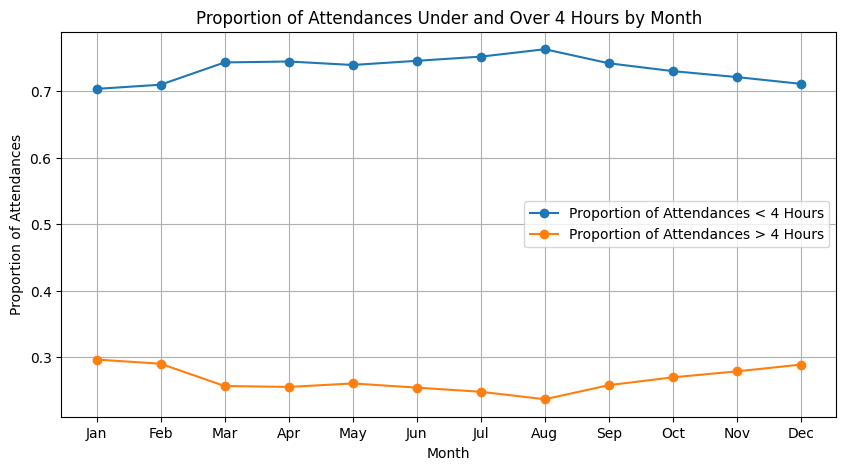

In [273]:
# Calculate and plot the proportion of attendances under and over 4 hours for each month
proportion_under_4_hours = combined_data.groupby('Month')['Total Attendances < 4 hours'].sum() / combined_data.groupby('Month')['Total Attendances'].sum()
proportion_over_4_hours = combined_data.groupby('Month')['Total Attendances > 4 hours'].sum() / combined_data.groupby('Month')['Total Attendances'].sum()

plt.figure(figsize=(10, 5))
plt.plot(proportion_under_4_hours, label="Proportion of Attendances < 4 Hours", marker='o')
plt.plot(proportion_over_4_hours, label="Proportion of Attendances > 4 Hours", marker='o')
plt.title("Proportion of Attendances Under and Over 4 Hours by Month")
plt.xlabel("Month")
plt.ylabel("Proportion of Attendances")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid()
plt.show()


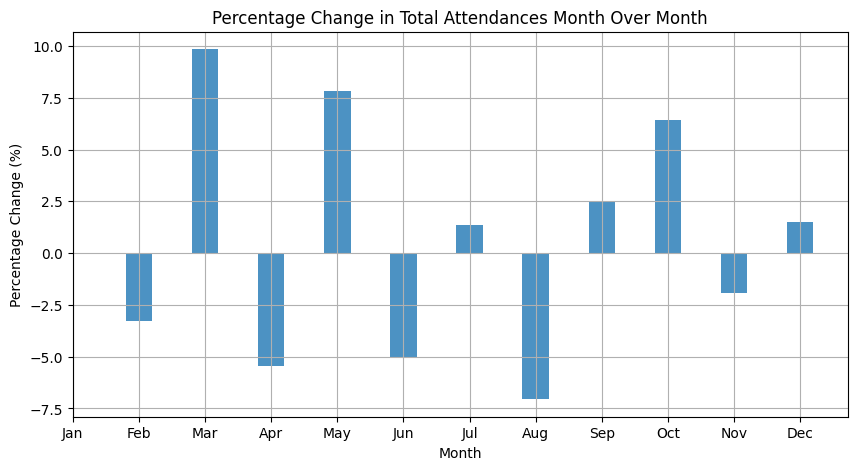

In [274]:
# Calculate percentage change in attendances month over month
combined_data['Total Attendances'] = combined_data['Total Attendances < 4 hours'] + combined_data['Total Attendances > 4 hours']
monthly_attendances = combined_data.groupby('Month')['Total Attendances'].sum()
percentage_change = monthly_attendances.pct_change() * 100

# Plot percentage change in attendances
plt.figure(figsize=(10, 5))
plt.bar(monthly_attendances.index, percentage_change, width=0.4, alpha=0.8)
plt.title("Percentage Change in Total Attendances Month Over Month")
plt.xlabel("Month")
plt.ylabel("Percentage Change (%)")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid()
plt.show()
